In [19]:
%matplotlib inline
from SALib.sample import saltelli
from SALib.analyze import sobol as sobol_analyze
from mesa.batchrunner import batch_run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output
import pickle
from joblib import Parallel, delayed
from SALib.sample import sobol
from SALib.sample import saltelli
from IPython.display import clear_output
import numpy as np
from itertools import product
import time
import random


from model import SugarscapeG1mt

In [2]:
# --- Sobol problem definitions (only names & bounds) ---

cont_vars_base = [
    "initial_population",
    "endowment_min",
    "endowment_max",
    "vision_min",
    "vision_max",
    "metabolism_min",
    "metabolism_max",
]
cont_bounds_base = [
    [50, 500],
    [0, 10],
    [15, 30],
    [1.0, 5.0],
    [5.0, 10.0],
    [0.1, 2.0],
    [2.0, 3.9],
]

staghunt_vars   = ["p_copy", "p_mutate"]
staghunt_bounds = [[0.0, 1.0], [0.0, 0.20]]

problem_off = {
    "num_vars": len(cont_vars_base),
    "names":    cont_vars_base,
    "bounds":   cont_bounds_base,
}

cont_vars_on   = cont_vars_base + staghunt_vars
cont_bounds_on = cont_bounds_base + staghunt_bounds

problem_on = {
    "num_vars": len(cont_vars_on),
    "names":    cont_vars_on,
    "bounds":   cont_bounds_on,
}

# --- Which parameters need integer‐rounding before the run? ---
integer_vars_off = {
    "initial_population",
    "endowment_min",
    "endowment_max",
    "wealth_tax_system",
    "income_tax_system",
    "wealth_tax_period",
}

# p_copy/p_mutate remain floats even when staghunt=ON:
integer_vars_on = integer_vars_off.copy()

# --- How to loop over your discrete slices ----------------
discrete_factors = {
    "wealth_tax_system": [0, 1, 2, 3],
    "income_tax_system": [0, 1, 2, 3],
    "enable_staghunt":   [0, 1],
}

wealth_tax_map = {0:"none", 1:"proportional", 2:"progressive", 3:"degressive"}
income_tax_map = {0:"none", 1:"proportional", 2:"progressive", 3:"degressive"}


In [7]:
measure = "Gini" # "Gini" # or "Avg Wealth"
second_order = True  # or: "True"Oh

# --- 3) Sobol GSA ---
replicates = 2
max_steps = 10
distinct_SA = 2

In [8]:
def run_mixed(run_id, params):
    # 1) Cast integer parameters (excluding enable_staghunt)
    for name in integer_vars_off:
        if name in params:
            params[name] = int(round(params[name]))

    # 2) Ensure ordering on min/max pairs
    for low, high, caster in [
        ("endowment_min", "endowment_max", int),
        ("vision_min",    "vision_max",    int),
        ("metabolism_min","metabolism_max",float),
    ]:
        lo, hi = sorted((params[low], params[high]))
        params[low], params[high] = caster(lo), caster(hi)

    # 3) Handle staghunt-dependent parameters
    # enable_staghunt is set in the driver loop (0 or 1)
    if not params.get("enable_staghunt", False):
        # staghunt OFF: force p_copy and p_mutate to zero
        params["p_copy"]   = 0.0
        params["p_mutate"] = 0.0

    # 4) Map policy codes to descriptive names
    params["wealth_tax_system"]  = wealth_tax_map[params["wealth_tax_system"]]
    params["income_tax_system"]  = income_tax_map[params["income_tax_system"]]

    # 5) Explicitly cast remaining floats
    params["flat_rate"]            = float(params.get("flat_rate", 0.0))
    params["income_tax_flat_rate"] = float(params.get("income_tax_flat_rate", 0.0))
    if "p_copy" in params:
        params["p_copy"]   = float(params["p_copy"])
        params["p_mutate"] = float(params["p_mutate"])

    # 6) Run the model and collect outputs
    out = batch_run(
        SugarscapeG1mt,
        parameters=params,
        iterations=1,
        max_steps=max_steps,
        data_collection_period=-1,
        display_progress=False
    )[0]

    # 7) Return merged params + model reporters
    return {
        **params,
        "RunId":      run_id,
        "Gini":       out["Gini"],
        "Avg Wealth": out["Average Wealth"]
    }


In [9]:
def run_mixed_safe(run_id, params):
    seed = 1 + run_id
    random.seed(seed)
    np.random.seed(seed)
    try:
        return run_mixed(run_id, params)
    except Exception as e:
        import traceback
        print(traceback.format_exc())
        raise e

all_records =[]
for w_sys in discrete_factors["wealth_tax_system"]:
    print(f"Running staghunt=OFF, wealth_tax={w_sys}")
    # Sample continuous inputs for staghunt OFF
    X = saltelli.sample(
        problem_off,
        distinct_SA,
        calc_second_order=second_order
    )
    # Build and run tasks
    tasks = []
    for run_id, cont_vals in enumerate(X):
        params = dict(zip(problem_off['names'], cont_vals))
        params.update({
            "wealth_tax_system":  w_sys,
            "income_tax_system":  w_sys,
            "enable_staghunt":    False,
        })
        tasks.append((run_id, params))

    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(run_mixed_safe)(rid, p) for rid, p in tasks
    )
    record = {
        "discrete_setting": (w_sys, w_sys, False),
        "samples":          X,
        "results":          results
    }
    all_records.append(record)
    with open(f"sobol_off_w{w_sys}.pkl", "wb") as f:
        pickle.dump(record, f)
    print(f"Saved sobol_off_w{w_sys}.pkl")

Running staghunt=OFF, wealth_tax=0


/var/folders/xz/r4qpf3bd2m3fdd46txvk5j0h0000gn/T/ipykernel_10122/2281488630.py:16: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  X = saltelli.sample(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  21 out of  32 | elapsed:    6.9s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  25 out of  32 | elapsed:    7.7s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:    8.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Saved sobol_off_w0.pkl
Running staghunt=OFF, wealth_tax=1


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  21 out of  32 | elapsed:    5.0s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  25 out of  32 | elapsed:    5.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:    6.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Saved sobol_off_w1.pkl
Running staghunt=OFF, wealth_tax=2


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  21 out of  32 | elapsed:    9.3s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  25 out of  32 | elapsed:   11.9s remaining:    3.3s


Saved sobol_off_w2.pkl
Running staghunt=OFF, wealth_tax=3


[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:   15.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   15.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  21 out of  32 | elapsed:    6.0s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  25 out of  32 | elapsed:    6.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:    7.1s remaining:    0.7s


Saved sobol_off_w3.pkl


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    7.4s finished


In [ ]:
# 0) user settings
desired_base_N = 64       # your “N” for sobol.sample(...)
replicates     = 5
second_order   = False

# 1) pick your discrete flags and problem
w_sys, i_sys, hunt_flag = 0, 0, False
problem = problem_off    # staghunt OFF
names   = problem['names']
D       = problem['num_vars']

# 2) draw the Sobol sample (first-order only)
X = sobol.sample(problem, desired_base_N, calc_second_order=second_order)

# 3) sanity check: how many rows did we really get?
batch_size    = D + 2
distinct_SA   = X.shape[0] // batch_size
print(f"len(X) = {len(X)}; expected {desired_base_N*(D + 2)}")
print(f"actual distinct_SA (batches) = {distinct_SA}")
print(f"Total tasks = {len(X)} × {replicates} = {len(X)*replicates}")

# 4) build tasks
tasks = []
for idx, cont_vals in enumerate(X):
    base = dict(zip(names, cont_vals))
    base.update({
        "wealth_tax_system":  w_sys,
        "income_tax_system":  i_sys,
        "enable_staghunt":    hunt_flag,
    })
    for rep in range(replicates):
        tasks.append((idx, rep, base.copy()))

# 5) run in parallel
def run_one(idx, rep, params):
    seed = 1 + idx + rep*10000
    random.seed(seed)
    np.random.seed(seed)
    return run_mixed(idx, params)["Gini"]

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_one)(idx, rep, params) for idx, rep, params in tasks
)

len(X) = 576; expected 576
actual distinct_SA (batches) = 64
Total tasks = 576 × 5 = 2880


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   16.7s
/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: D

In [22]:
# right before aggregation, dump some diagnostics:
idxs = [t[0] for t in tasks]
print("Number of tasks:", len(tasks))
print("Number of results:", len(results))
print("Min index:", min(idxs), "Max index:", max(idxs))
print("Distinct sample IDs:", len(set(idxs)))

from collections import Counter
ctr = Counter(idxs)
print("Counts per sample ID (showing any > replicates):")
for sample_id, count in ctr.items():
    if count != replicates:      # you expect exactly `replicates` per sample
        print(f"  sample {sample_id} has {count} runs")

# you can also peek at the very first few
print("\nFirst 10 (idx, rep, Gini):")
for ((idx, rep, _), g) in list(zip(tasks, results))[:10]:
    print(idx, rep, g)

Number of tasks: 2880
Number of results: 2880
Min index: 0 Max index: 575
Distinct sample IDs: 576
Counts per sample ID (showing any > replicates):

First 10 (idx, rep, Gini):
0 0 0.2362286646320667
0 1 0.23026044537605583
0 2 0.22433297564134846
0 3 0.24605571996279052
0 4 0.23124149107161363
1 0 0.22403779609953037
1 1 0.20544920599923214
1 2 0.2140132538524955
1 3 0.219007403612297
1 4 0.24385767518593562


/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


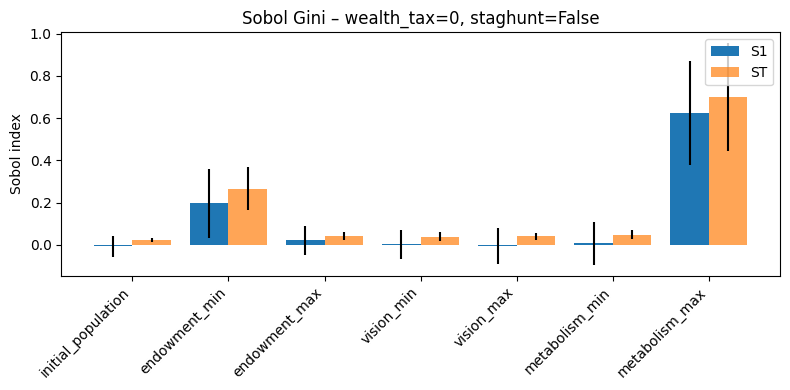

In [25]:
from collections import defaultdict

# 1a) Gather Gini by row index
row_ginis = defaultdict(list)
for (row_idx, rep, _), g in zip(tasks, results):
    row_ginis[row_idx].append(g)

# 1b) Sanity‐check: you should have exactly `replicates` entries per row
assert all(len(v) == replicates for v in row_ginis.values()), \
       "Some rows don't have the right number of replicates"

# 1c) Build Y: one mean Gini per row of X
Y = np.array([np.mean(row_ginis[i]) for i in range(len(X))], dtype=float)
# 4) Sobol analysis
Si = sobol_analyze.analyze(
    problem,
    Y,
    calc_second_order=second_order,
    print_to_console=False
)

# 5) plotting S1 vs ST
x      = np.arange(D)
S1, ST = Si["S1"], Si["ST"]
c1, cT = Si["S1_conf"], Si["ST_conf"]

plt.figure(figsize=(8,4))
plt.bar(x-0.2, S1, width=0.4, yerr=c1, label="S1")
plt.bar(x+0.2, ST, width=0.4, yerr=cT, label="ST", alpha=0.7)
plt.xticks(x, names, rotation=45, ha="right")
plt.ylabel("Sobol index")
plt.title(f"Sobol Gini – wealth_tax={w_sys}, staghunt={hunt_flag}")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# Pick exactly one setting (e.g. index 0, or find by w_sys)
rec = all_records[0]
w_sys, i_sys, hunt_flag = rec['discrete_setting']
problem = problem_off if not hunt_flag else problem_on
names   = problem['names']

# Extract Gini outputs
Y = np.array([r['Gini'] for r in rec['results']], dtype=float)

# Perform Sobol analysis with resampling kept for bootstrap
Si = sobol_analyze.analyze(
    problem,
    Y,
    calc_second_order=second_order,    # or True if you sampled 2nd-order
    num_resamples=500,
    conf_level=0.95,
    print_to_console=False,
    keep_resamples=True
)

S1      = Si["S1"]
ST      = Si["ST"]
S1_conf = Si["S1_conf"]
ST_conf = Si["ST_conf"]
names   = problem["names"]

print(f"Testing ST > S1 at 95% for setting wealth_tax={w_sys}, staghunt={hunt_flag}\n")

for i, name in enumerate(names):
    # Compute the CI bounds
    S1_upper = S1[i] + S1_conf[i]
    ST_lower = ST[i] - ST_conf[i]

    # Test if ST_lower exceeds S1_upper
    significant = ST_lower > S1_upper

    print(f"{name:15s}   S1 = {S1[i]:.3f} ± {S1_conf[i]:.3f}   "
          f"ST = {ST[i]:.3f} ± {ST_conf[i]:.3f}   "
          f"{'ST>S1 ✓' if significant else 'ST≈S1'}")

Testing ST > S1 at 95% for setting wealth_tax=0, staghunt=False

initial_population   S1 = 0.386 ± 2.291   ST = 0.080 ± 0.570   ST≈S1
endowment_min     S1 = 0.331 ± 2.121   ST = 0.064 ± 0.458   ST≈S1
endowment_max     S1 = 0.567 ± 4.435   ST = 0.219 ± 1.580   ST≈S1
vision_min        S1 = 0.678 ± 3.927   ST = 0.192 ± 1.185   ST≈S1
vision_max        S1 = 0.291 ± 2.032   ST = 0.053 ± 0.382   ST≈S1
metabolism_min    S1 = 0.391 ± 3.833   ST = 0.124 ± 0.872   ST≈S1
metabolism_max    S1 = 0.091 ± 2.257   ST = 0.005 ± 0.116   ST≈S1


/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


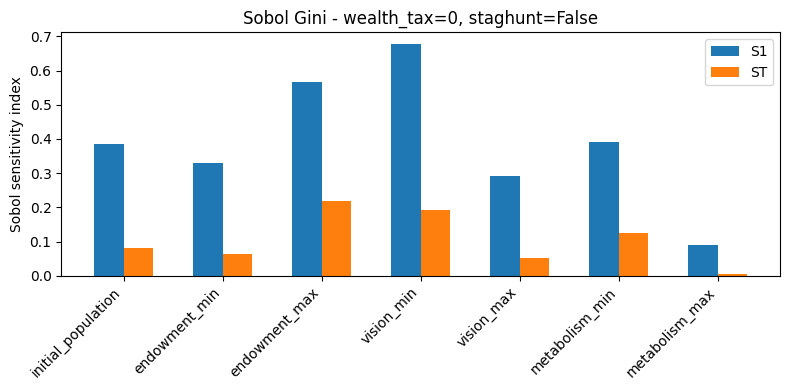

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


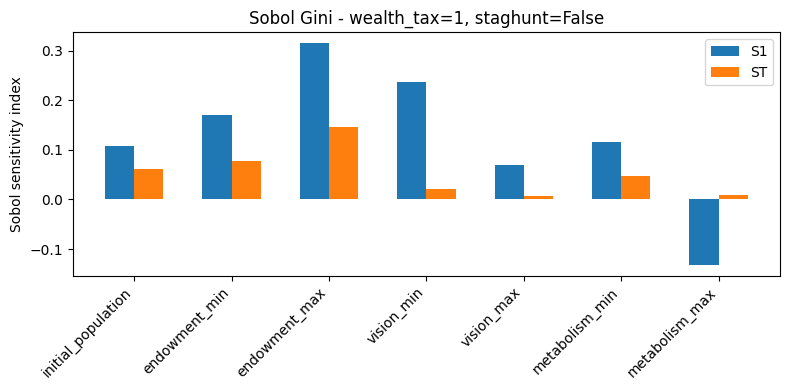

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


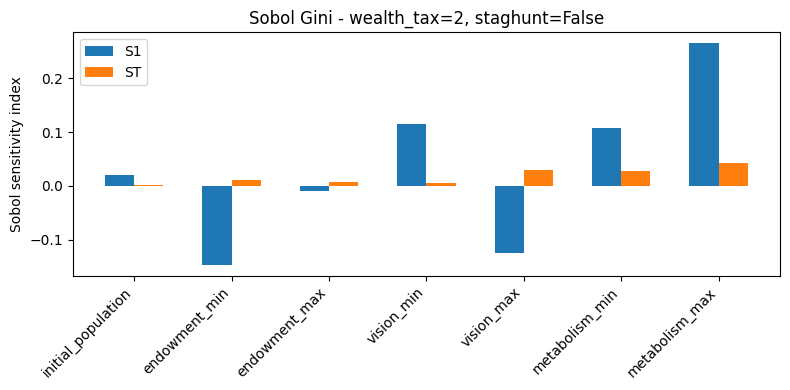

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


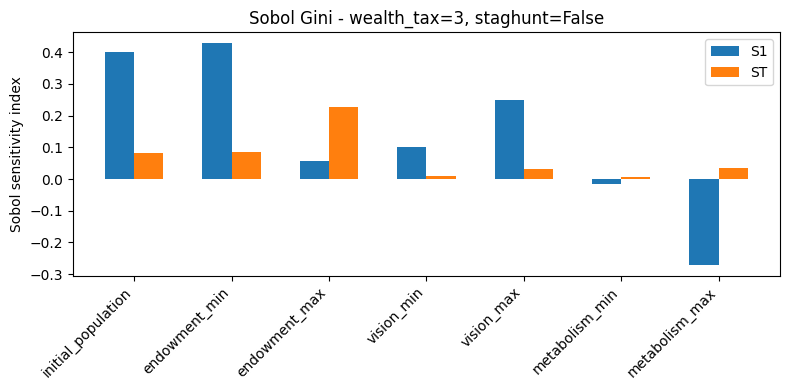

In [10]:
for rec in all_records:
    w_sys, i_sys, hunt_flag = rec['discrete_setting']
    # Choose appropriate problem dict for analysis
    problem = problem_off if not hunt_flag else problem_on
    names = problem['names']

    # Extract Gini values
    Y = np.array([r['Gini'] for r in rec['results']], dtype=float)

    # Perform Sobol analysis
    Si = sobol_analyze.analyze(
        problem,
        Y,
        calc_second_order=second_order,
        print_to_console=False
    )

    # Plot S1 vs ST
    S1 = Si['S1']
    ST = Si['ST']
    x = np.arange(len(names))

    plt.figure(figsize=(8,4))
    plt.bar(x - 0.15, S1, width=0.3, label='S1')
    plt.bar(x + 0.15, ST, width=0.3, label='ST')
    plt.xticks(x, names, rotation=45, ha='right')
    plt.ylabel('Sobol sensitivity index')
    plt.title(f"Sobol Gini - wealth_tax={w_sys}, staghunt={hunt_flag}")
    plt.legend()
    plt.tight_layout()
    plt.show()